In [41]:
import torch
from torch import nn,optim
from torchvision import datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

In [42]:
batch_size = 50

train = dsets.MNIST(root = './data', train = True, transform=transforms.ToTensor(), download=True)
valid = dsets.MNIST(root = './data', train = False, transform=transforms.ToTensor(), download=True)

sample_set_size = 60000
indices = torch.randperm(len(train))[:sample_set_size]
train_loader = DataLoader(dataset = train, batch_size = batch_size, sampler=SubsetRandomSampler                           (indices))
val_loader = DataLoader(dataset = valid, batch_size = 10000, shuffle = True)

In [43]:
class CNN(nn.Module):

    def __init__(self, out1 = 16, out2 = 32):
        super(CNN, self).__init__()

        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=2, padding=3, stride=1), 
                                        nn.BatchNorm2d(out1), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=2, padding=3, stride=1), 
                                        nn.BatchNorm2d(out2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        self.fc = nn.Sequential(nn.Linear(10 * 10 * out2, 100), nn.BatchNorm1d(100), nn.ReLU(), nn.Linear(100,10))


    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        return x

In [44]:
def train_model(model, epochs, learning_rate, final_lr, train_loader, val_loader, momentum):

    epoch_loss = []
    accuracy = []
    all_loss = []
    criterion = nn.CrossEntropyLoss()
    num_batches = len(list(train_loader))
    print(f'{num_batches} batches per epoch.')

    lr_decay = (final_lr - learning_rate) / int((3/4) * epochs)

    for epoch in range(epochs):
        model.train()
        opt = optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)

        print('EPOCH : ', epoch + 1)
        print('Batch : ', end = '')
        counter = 0
        mean_loss_list = []
        for x,y in train_loader :

            opt.zero_grad()
            yhat = model.forward(x)

            loss = criterion(yhat,y)
            mean_loss_list.append(loss.item())
            all_loss.append(loss.item())

            loss.backward()
            opt.step()

            if counter % (num_batches/20) == 0 : 
                print(str(counter) + ' --> ', end = '', flush = True)
            counter += 1

        mean_loss = mean(mean_loss_list)
        epoch_loss.append(mean_loss)

        correct = 0
        incorrect = 0

        for x,y in val_loader :
            model.eval()

            yhat = model.forward(x)

            for i in range(yhat.shape[0]):
                pred = yhat[i].argmax().item()
                actual = y[i].item()

                if pred == actual :
                    correct += 1
                else :
                    incorrect += 1
        
        acc = (correct / (correct + incorrect)) * 100
        accuracy.append(acc)

        print()
        print('Mean loss : ', mean_loss)
        print(f'Accuracy on test set : {acc} %')
        print('-' * 50)

        learning_rate = learning_rate - lr_decay

    return epoch_loss, all_loss, accuracy

In [45]:
model = CNN()
epochs = 5
lr = 0.0085
momentum = 0.85
loss, all_loss, acc = train_model(model = model, epochs = epochs, learning_rate = lr, final_lr = lr/5, train_loader = train_loader, val_loader = val_loader, momentum = momentum)

1200 batches per epoch.
EPOCH :  1
Batch : 0 --> 60 --> 120 --> 180 --> 240 --> 300 --> 360 --> 420 --> 480 --> 540 --> 600 --> 660 --> 720 --> 780 --> 840 --> 900 --> 960 --> 1020 --> 1080 --> 1140 --> 
Mean loss :  0.1416462821428043
Accuracy on test set : 98.19 %
--------------------------------------------------
EPOCH :  2
Batch : 0 --> 60 --> 120 --> 180 --> 240 --> 300 --> 360 --> 420 --> 480 --> 540 --> 600 --> 660 --> 720 --> 780 --> 840 --> 900 --> 960 --> 1020 --> 1080 --> 1140 --> 
Mean loss :  0.056789012823913555
Accuracy on test set : 98.81 %
--------------------------------------------------
EPOCH :  3
Batch : 0 --> 60 --> 120 --> 180 --> 240 --> 300 --> 360 --> 420 --> 480 --> 540 --> 600 --> 660 --> 720 --> 780 --> 840 --> 900 --> 960 --> 1020 --> 1080 --> 1140 --> 
Mean loss :  0.04183529505234522
Accuracy on test set : 98.79 %
--------------------------------------------------
EPOCH :  4
Batch : 0 --> 60 --> 120 --> 180 --> 240 --> 300 --> 360 --> 420 --> 480 --> 540

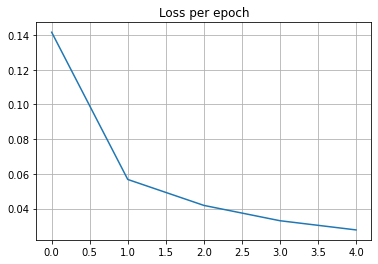

In [46]:
plt.title('Loss per epoch')
plt.plot(loss)
plt.grid(True)
plt.show()

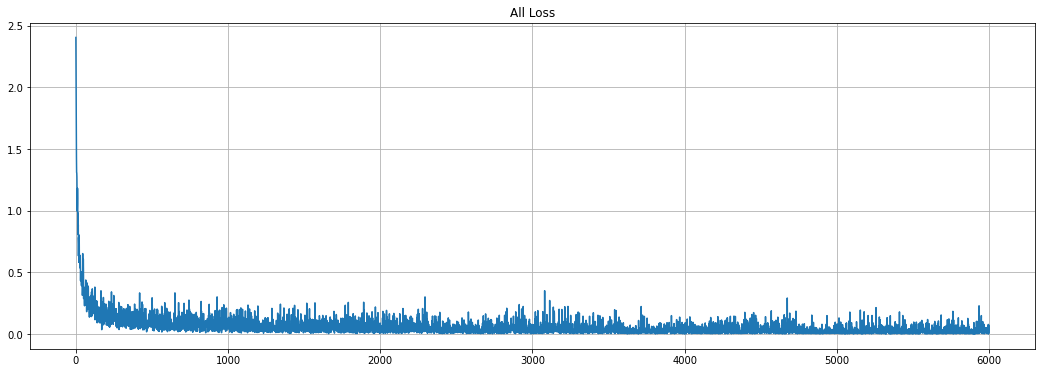

In [47]:
plt.figure(figsize = (18,6))
plt.title('All Loss')
plt.plot(all_loss)
plt.grid(True)
plt.show()

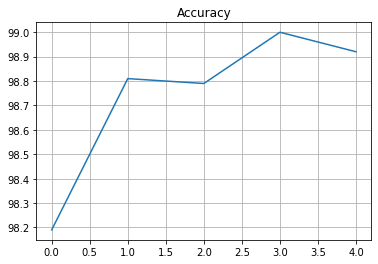

In [48]:
plt.title('Accuracy')
plt.plot(acc)
plt.grid(True)
plt.show()